In [1]:
import os
import glob
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
# 啟用混合精度訓練
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [3]:
# 圖片大小設置
img_size = 128

In [ ]:
# 資料路徑 (獅子與豹的資料夾路徑)
lion_dir = r'C:\Users\Louis\Desktop\git-repos\myenv\data_augmented\lion'
leopard_dir = r'C:\Users\Louis\Desktop\git-repos\myenv\data_augmented\leopard'

In [5]:
# 定義分類
categories = ['lion', 'leopard']

In [6]:
# 準備資料集
data = []
labels = []

In [7]:
# 加載獅子的圖片
for img_path in glob.glob(os.path.join(lion_dir, '*.jpg')):
    try:
        img_array = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
        img_array = tf.keras.preprocessing.image.img_to_array(img_array)
        data.append(img_array)
        labels.append(categories.index('lion'))  # 獅子的標籤為 0
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

In [8]:
# 加載豹的圖片
for img_path in glob.glob(os.path.join(leopard_dir, '*.jpg')):
    try:
        img_array = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
        img_array = tf.keras.preprocessing.image.img_to_array(img_array)
        data.append(img_array)
        labels.append(categories.index('leopard'))  # 豹的標籤為 1
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

In [9]:
# 轉為 NumPy 陣列且標準化
data = np.array(data, dtype='float32') / 255.0
labels = np.array(labels)

In [10]:
# 轉為 one-hot 編碼
labels = tf.keras.utils.to_categorical(labels, num_classes=2)


In [11]:
# 分割訓練集、驗證集和測試集 (80% 訓練集, 10% 驗證集, 10% 測試集)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2, random_state=42)


In [12]:
# 將剩下的 20% 再分割為 10% 驗證集和 10% 測試集
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [13]:
# 檢查各個數據集的形狀
print(f"訓練集大小: {X_train.shape[0]} 張")
print(f"驗證集大小: {X_val.shape[0]} 張")
print(f"測試集大小: {X_test.shape[0]} 張")

訓練集大小: 3635 張
驗證集大小: 454 張
測試集大小: 455 張


In [14]:
# 定義模型
model = Sequential()

In [15]:
# 1. 增加卷積層和池化層
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(img_size, img_size, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# 平坦層和全連接層
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))

# 輸出層
model.add(Dense(units=2, activation='softmax', dtype='float32'))


In [16]:
# 設定模型訓練方式
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
# 觀察模型結構
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0

In [18]:
# 訓練模型
train_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=16, verbose=2)

Epoch 1/5
228/228 - 14s - loss: 0.6151 - accuracy: 0.6713 - val_loss: 0.5431 - val_accuracy: 0.7555 - 14s/epoch - 61ms/step
Epoch 2/5
228/228 - 9s - loss: 0.4257 - accuracy: 0.8198 - val_loss: 0.3529 - val_accuracy: 0.8436 - 9s/epoch - 41ms/step
Epoch 3/5
228/228 - 10s - loss: 0.3753 - accuracy: 0.8421 - val_loss: 0.3476 - val_accuracy: 0.8612 - 10s/epoch - 42ms/step
Epoch 4/5
228/228 - 10s - loss: 0.3291 - accuracy: 0.8655 - val_loss: 0.3332 - val_accuracy: 0.8634 - 10s/epoch - 43ms/step
Epoch 5/5
228/228 - 10s - loss: 0.2969 - accuracy: 0.8773 - val_loss: 0.2848 - val_accuracy: 0.8767 - 10s/epoch - 44ms/step


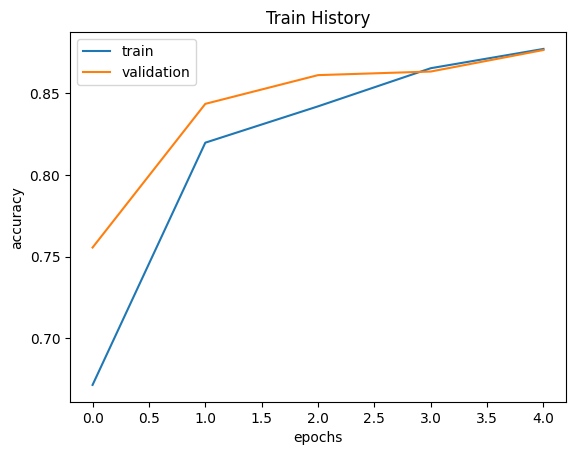

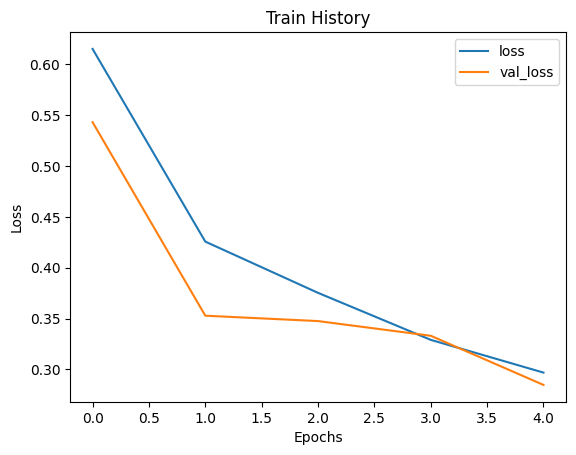

In [19]:
# 繪製準確率和損失率圖表
plt.title("Train History")
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train", "validation"])
plt.show()

plt.plot(train_history.history['loss'], label='loss')
plt.plot(train_history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train History')
plt.legend()
plt.show()

In [20]:
# 評估模型
scores = model.evaluate(X_test, y_test, verbose=0)
print('\n準確率:', scores[1])
print('損失率:', scores[0])


準確率: 0.8703296780586243
損失率: 0.2807818353176117


In [21]:
# 進行預測
val_predictions = model.predict(X_val)
val_predicted_classes = np.argmax(val_predictions, axis=1)


15/15 [==============================] - 1s 40ms/step


In [22]:
# 將資料轉為一維
y_val = np.argmax(y_val, axis=1)


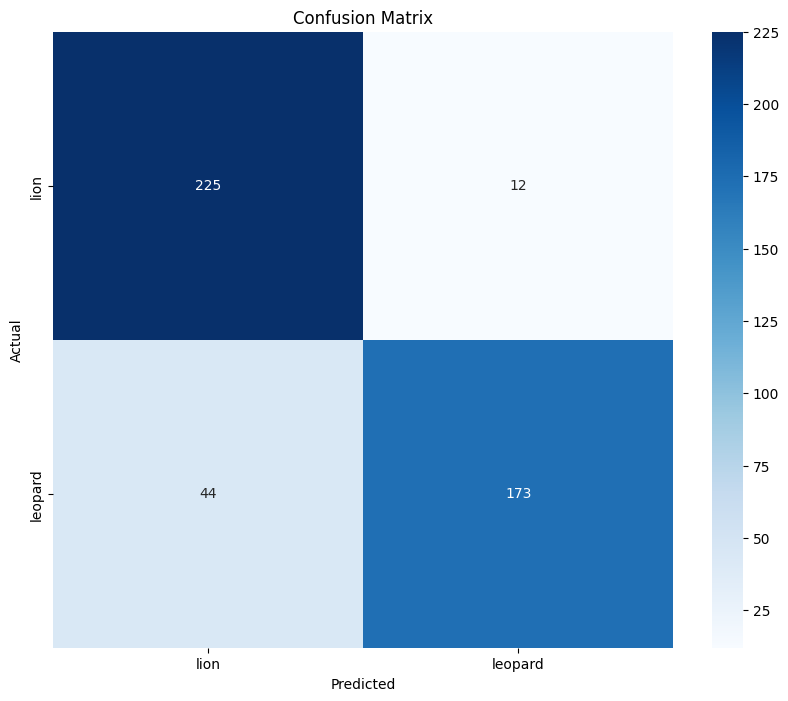

In [23]:
# 繪製混淆矩陣
conf_mat = confusion_matrix(y_val, val_predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# 計算並顯示準確率、精確率、召回率和F1-score
report = classification_report(y_val, val_predicted_classes, target_names=categories, output_dict=True)
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
print(f"準確率: {accuracy}")
print(f"精確率: {precision}")
print(f"召回率: {recall}")
print(f"F1-score: {f1_score}")

準確率: 0.8766519823788547
精確率: 0.8836090860524642
召回率: 0.8766519823788547
F1-score: 0.8756429411161879


In [22]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1
